# Рекомендация тарифов

Цель -  построить модели для задачи классификации, которая выберет подходящий тариф с максимально большим значением *accuracy*. 

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
+ сalls — количество звонков,
+ minutes — суммарная длительность звонков в минутах,
+ messages — количество sms-сообщений,
+ mb_used — израсходованный интернет-трафик в Мб,
+ is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Содержание проекта

[1. Изучение общей информации](#1)  
+ [Вывод](#end_1)  

[2. Разбиение данных на выборки](#2)  
+ [Вывод](#end_2)  

[3. Исследование модели](#3)  
+ [Решающее дерево](#3.1)  
+ [Случайный лес](#3.2)  
+ [Логистическая регрессия](#3.3)  
+ [Вывод](#end_3) 

[4. Проверка модели на тестовой выборке](#4)  
+ [Вывод](#end_4) 

[5. Проверка модели на адекватность](#5)  
+ [Вывод](#end_5) 

[6. Общий вывод](#6)  

## 1. Изучение общей информации<a id="1"></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

In [3]:
display(tariff.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

In [4]:
display(tariff.describe())

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
display(tariff.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [6]:
display(tariff.duplicated().sum())

0

Исходные данные не нуждаются в предварительной обработке, можем сразу приступить к их исследованию.

## 2. Разбиение данных на выборки<a id="2"></a>

In [7]:
# Выделим валидационную выборку
df_train, df_valid = train_test_split(tariff, test_size=0.20, random_state=12345)

In [8]:
# Выделим тестовую выборку
df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=12345)

In [9]:
print(df_valid.shape)
print(df_test.shape)
print(df_train.shape)

(643, 5)
(643, 5)
(1928, 5)


In [10]:
# создадим переменные для исследования моделей
features_train = df_train.drop('is_ultra', axis = 1)
features_valid = df_valid.drop('is_ultra', axis = 1)
features_test = df_test.drop('is_ultra', axis = 1)

target_train = df_train['is_ultra']
target_valid = df_valid['is_ultra']
target_test = df_test['is_ultra']

In [11]:
# Посмотрим, насколько сбалансирована выборка
df_train.query('is_ultra == 0').shape

(1339, 5)

In [12]:
df_train.query('is_ultra == 1').shape

(589, 5)

## Вывод<a id="end_2"></a>

Выделены обучающая, тестовая и валидационная выборки. Созданы переменные для последующего моделирования.

## 3. Исследование модели<a id="3"></a>

### 3.1 Решающее дерево<a id="3.1"></a>

Исследуем качество модели "Решающее дерево" для разных значений глобальных параметров модели на валидационных данных.  
Т.к. по условиям задачи основным критерием качества у нас является значение "правильности" - accuracy, предварительно оценим какие значения "глубины дерева" max_depth дают нам максимальные accuracy, далее уже для них добавим проверку параметров min_samples_split, min_samples_leaf.

In [13]:
result = {}
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    result[depth] = accuracy
 

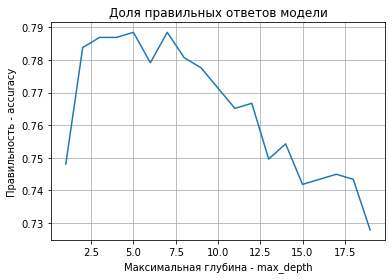

In [14]:
plt.plot(list(result.keys()), list(result.values()))
plt.title('Доля правильных ответов модели')
plt.xlabel("Максимальная глубина - max_depth")
plt.ylabel("Правильность - accuracy")
plt.grid()
plt.show()


При значении max_depth = (4, 7] обеспечивается максимальная доля правильных ответов, в этом диапазоне далее и будем проводить проверку. 

Оценим влияние параметров criterion, min_samples_split, min_samples_leaf на изменение правильности предсказания модели.

In [15]:
%%time
scores_data = pd.DataFrame()
for depth in range(4, 8): 
    for split in range(2, 40):
        for leaf in range(1, 20):
            for criterion in ['gini', 'entropy']:
                model = DecisionTreeClassifier(criterion = criterion, random_state=12345, max_depth=depth, min_samples_split = split, min_samples_leaf = leaf)
                model.fit(features_train, target_train)
                accuracy = model.score(features_valid, target_valid)
                tmp_scores_data = pd.DataFrame({'criterion': [criterion], 'max_depth': [depth], 'split': [split], 'leaf': [leaf], 'accuracy':[accuracy]})
                scores_data = scores_data.append(tmp_scores_data)
            

Wall time: 1min 2s


In [16]:
display(scores_data.sort_values(by = 'accuracy', ascending = False).head(10))

,criterion,max_depth,split,leaf,accuracy
0,entropy,6,23,4,0.807154
0,entropy,6,19,4,0.807154
0,entropy,6,18,4,0.807154
0,entropy,6,21,4,0.807154
0,entropy,6,22,4,0.807154
0,entropy,6,20,4,0.807154
0,entropy,6,28,4,0.805599
0,entropy,6,24,4,0.805599
0,entropy,6,25,4,0.805599
0,entropy,6,27,4,0.805599


Оценим параметры Precision, Recall и F1-score  для эмпирически подобранных глобальных параметров.

In [17]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_leaf = 4, min_samples_split = 23)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
print(classification_report(target_valid, predictions_valid))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       447
           1       0.83      0.40      0.54       196

    accuracy                           0.79       643
   macro avg       0.81      0.68      0.70       643
weighted avg       0.80      0.79      0.77       643



В качестве эксперимента, проведем автоматический подбор параметров модели с помощью модуля GridSearchCV и далее сравним полученные эмпирические и автоматические параметры. В данном случае наши валидационные данные фактически будут выполнять функцию тестовых.

In [18]:
%%time
clf = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,10), 'min_samples_split': range(2,40, 2), 'min_samples_leaf': range(1,20)}
grid = GridSearchCV(clf, parameters, cv=5) #cv - кол-во групп для кросс-валидации
grid.fit(features_train, target_train)
print('Оптимальные параметры модели:', grid.best_params_)
print('Значение accuracy:', grid.score(features_valid, target_valid))

Оптимальные параметры модели: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 36}
Значение accuracy: 0.7884914463452566
Wall time: 4min 50s


In [19]:
model = DecisionTreeClassifier(criterion = 'gini', random_state=12345, max_depth=8, min_samples_leaf = 12, min_samples_split = 36)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
print(classification_report(target_valid, predictions_valid))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       447
           1       0.73      0.48      0.58       196

    accuracy                           0.79       643
   macro avg       0.77      0.70      0.72       643
weighted avg       0.78      0.79      0.77       643



### Вывод

Результаты показывают, что получены как идентичные значения accuracy, так и достачточно близкие значения precision и recall. Это говорит о том, что подобранные вручную параметры модели являются удовлетворительными.  


### 3.2 Случайный лес<a id="3.2"></a>

Аналогично решающему дереву , переберем в цикле глобальные параметры модели, выберем оптмальные по значению accuracy.

In [20]:
scores_data = pd.DataFrame()
for est in range(1, 11):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        accuracy = model.score(features_valid, target_valid) 
        tmp_scores_data = pd.DataFrame({'max_depth': [depth], 'n_estimators': [est], 'accuracy':[accuracy]})
        scores_data = scores_data.append(tmp_scores_data)
           


In [21]:
display(scores_data.sort_values(by = 'accuracy', ascending = False).head(10))

,max_depth,n_estimators,accuracy
0,7,3,0.802488
0,7,5,0.800933
0,7,4,0.799378
0,7,2,0.799378
0,9,9,0.797823
0,8,5,0.796267
0,6,6,0.796267
0,6,7,0.796267
0,6,4,0.794712
0,6,9,0.794712


Оценим параметры Precision, Recall и F1-score  для эмпирически подобранных глобальных параметров.

In [22]:
model = RandomForestClassifier(random_state=12345, n_estimators=3, max_depth=7)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
print(classification_report(target_valid, predictions_valid))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       447
           1       0.78      0.49      0.60       196

    accuracy                           0.80       643
   macro avg       0.79      0.72      0.74       643
weighted avg       0.80      0.80      0.79       643



Аналогично, проведем автоматический подбор параметров с помощью GridSearchCV:

In [23]:
%%time
clf_rf = RandomForestClassifier()
parameters = {'n_estimators': range(1, 30), 'max_depth': range(1, 11)}
grid = GridSearchCV(clf_rf, parameters, cv=5) #cv - кол-во групп для кросс-валидации
grid.fit(features_train, target_train)
print('Оптимальные параметры модели:', grid.best_params_)
print('Значение accuracy:', grid.score(features_valid, target_valid))


Оптимальные параметры модели: {'max_depth': 8, 'n_estimators': 25}
Значение accuracy: 0.7993779160186625
Wall time: 1min 16s


In [24]:
model = RandomForestClassifier(random_state=12345, n_estimators=25, max_depth=10)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
print(classification_report(target_valid, predictions_valid))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       447
           1       0.74      0.48      0.59       196

    accuracy                           0.79       643
   macro avg       0.77      0.71      0.72       643
weighted avg       0.79      0.79      0.78       643



### Вывод

Получили значение acuracy, аналогичное модели "Решающее дерево". Показатели точности(precision) и полноты (recall) также очень близки.

### 3.3 Логистическая регрессия<a id="3.3"></a>

Аналогично предыдущим пунктам, построим обучим модель Логистической регрессии, посчитаем значение accuracy.

In [25]:
model = LogisticRegression(random_state=12345) 
model.fit(features_train, target_train) 
result = model.score(features_valid, target_valid)
predictions_valid = model.predict(features_valid)

In [26]:
print(result)

0.7589424572317263


In [27]:
print(classification_report(target_valid, predictions_valid))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85       447
           1       0.89      0.24      0.38       196

    accuracy                           0.76       643
   macro avg       0.82      0.61      0.61       643
weighted avg       0.79      0.76      0.71       643



### Вывод

Модель логистической регрессии показывают худшие результаты по сравнению с Решающим деревои и Случайным лесом по значению accuracy.  Т.к. значение accuracy не является достоверным показателем качества, учитывая, что у нас есть дисбаланс классов в исходной выборке, можем сравнить значения F1- score этих двух моделей. Видим, что сравнение также не в пользу Логистической регрессии.
В частности, значение полноты сильно отличается от аналогичного показателя предыдущих моделей, которое говорит о том , что наша модель смогла определить лишь 24 % объектов класса 1 и  99 % класса 0.

## Вывод<a id="end_3"></a>

На основании вышеприведенного анализа можем сделать однозначный вывод, что модели "Решающее дерево" и "Случайный лес" показывают практически идентичные показатели качества (accuracy = 0,79). Для дальнейшей работы остановим свой выбор на модели "Случайный лес", учитывая , что теоретически она является более точной и обеспечивающей лучший результат, хотя на наших данных такого однозначного вывода мы сделать не можем.  
Модель "Логистическая регрессия" показала худшие результаты качества, оцениваемого значением accuracy.

## 4. Проверка модели на тестовой выборке<a id="4"></a>

Для проверки выбранной модели и ее глобальных параметров, предварительно объединим обучающую и валидационную выборки, для получения бОльшего обучающего объема, заново обучим на них модель с уже определенными выше глобальными параметрами , а затем проверим ее на тестовых данных. 

In [28]:
df_train_res = pd.concat([df_train, df_valid], ignore_index=True)
features_train_res = df_train_res.drop('is_ultra', axis = 1)
target_train_res = df_train_res['is_ultra']


In [29]:
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=9) 
model.fit(features_train_res, target_train_res) 
predictions_test = model.predict(features_test)
print(classification_report(target_test, predictions_test))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       443
           1       0.77      0.46      0.58       200

    accuracy                           0.79       643
   macro avg       0.78      0.70      0.72       643
weighted avg       0.79      0.79      0.77       643



## Вывод<a id="end_4"></a>

Полученное значение accuracy, равное 0,79 удовлетворяет поставленным задачей условиям (значение больше 0,75).  
Полученные значения precision (точности) говорят о 79-77% точности отнесения элемента выборки к своему классу, значение полноты (recall)  о 94-46% доле найденных экземпляров для 0/1 классов или тарифов Смарт/Ультра соответственно.   
В целом, полученные результаты можем считать удовлетворительными.


## 5. Проверка модели на адекватность<a id="5"></a>

Для проверки модели на адекватность применим фиктивный классификатор DummyClassifier, с параметром "most_frequent", который всегда будет выдавать наиболее частый класс выборки, т.е. 0

In [30]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(features_train_res, target_train_res)
accuracy = dummy_classifier.score(features_test, target_test)
print(accuracy)

0.6889580093312597


## Вывод<a id="end_5"></a>

Значение accuracy для такой модели равняется 0.69, что ниже соответствующего значения "боевой" модели, т.о. можем сделать вывод о ее адекватности.

## 6. Общий вывод<a id="6"></a>

Было проведено исследование трех моделей: "Решающее дерево", "Случайный лес", "Логистическая регрессия".  
На основании проведенного анализа выбрали модель, которя наилучшим образом предсказывает значение тарифного плана.  
Значение полученного accuracy для модели "Случайный лес" составило 0.79, что удовлетворяет условиям проекта .  
Выбранная модель проверена на адекватность с использованием фиктивного классификатора.   
